<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo08-word-embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harry Potter and Word Embedding

We view words as having meaning but our representation of them is arbitrary and meaningless to computers.
When working with natural language, the first step is to convert words into vectors.

Our goal is to represent words in a vector space where similar words are close to each other. The problem is challenging because the meaning of words is not transitive. For example, the word "wizard" is similar to both "witch" and "man" but "witch" is not similar to "man".

### word2vec

A popular approach for getting meaninful word embeddings is called word2vec and first proposed in [this](https://arxiv.org/pdf/1301.3781.pdf) paper. The key concept is to find words that are similar to each other. We do this by scanning text and identifying words that appear next to each other as similar. Consider two similar words $x$ and $y$.

![](https://lilianweng.github.io/posts/2017-10-15-word-embedding/word2vec-skip-gram.png)

The idea is to represent $x$ as a one-hot encoding (similar to how we represent classes). Call the dimension of the space $V$ (this is the number of unique words). Then we apply a fully connected layer to represent the one-hot encoded word in a small hidden dimension $N$. The hidden dimension representation is the vector representing the word.

In order to make the representation meaningful, we will apply a second fully connected layer to convert the hidden dimension back to the one-hot encoded dimension $V$. Now, we train both layers using cross entropy loss so that on input $x$, we get output close to $y$.

Now there are two issues with this approach:

* We train two layers but we only use the first word one to encode a word.

* We really want the embedding of the two similar words $x$ and $y$ to be close. However, the loss function we use is more complicated.

### Contrastive Learning

A more direct approach to get meaningful vector representation is to use *contrastive learning*. The key concept is that we have positive pairs $(x,y)$ whose vector representations we want to be close and negative pairs $(x,z)$ whose vector representations we want to be far apart.

Let $f$ be the network we apply to the words to embed them. If we use the inner product as our notion of similarity, then the loss function is

$$ L(f) =
\sum_{\text{positive pairs $(x,y)$}} (\langle f(x),f(y) \rangle-1)^2
+ \sum_{\text{negative pairs $(x,z)$}} (\langle f(x),f(z) \rangle)^2
$$

This forces the inner product between positive pairs to be large and the inner product between negative pairs to be small.

Note: The loss function we just described is one of many loss functions used for contrastive learning.

Because contrastive learning tends to work better and is more direct, we will show how to use it to embed words today. The text we'll use for finding positive and negative pairs of words is Harry Potter!


## Libraries

As always, we rely on a lot of libraries.

In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.request
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

## Loading Text

We load the text of Harry Potter from a website and preprocess it. In particular, we only want the chapters of the book and we make all words lowercase. Finally, we remove annoying characters like new lines.

In [2]:
url1 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Sorcerer's%20Stone.txt"
url2 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Chamber%20of%20Secrets.txt"
url3 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Prisoner%20of%20Azkaban%20.txt"
url4 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Goblet%20of%20Fire.txt"
url5 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Order%20of%20the%20Phoenix.txt"
url6 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20The%20Half-Blood%20Prince.txt"
url7 = "https://raw.githubusercontent.com/bobdeng/owlreader/7c3e507853b07273421d83e220c2ef219b8b6122/ERead/assets/books/Harry%20Potter%20and%20the%20Deathly%20Hallows%20.txt"

def read_file(url):
  remove = ['\u3000', '\n', '¬', ',', '.']
  with urllib.request.urlopen(url) as webpage:
    text = webpage.read().decode("utf8").lower()
    for to_remove in remove:
      text = text.replace(to_remove, '')
  return text

text1 = read_file(url1)
text2 = read_file(url2)
text3 = read_file(url3)
text4 = read_file(url4)
text5 = read_file(url5)
text6 = read_file(url6)
text7 = read_file(url7)

text = text1 + text2 + text3 + text4 + text5 + text6 + text7

## Tokenizing

Now we tokenize the text. That is, we turn the string into a list of words.

In [3]:
def get_frequent(tokens, threshold=50):
  frequency = {token : 0 for token in set(tokens)}
  for token in tokens:
    frequency[token] += 1

  frequent_tokens = []
  for token in tokens:
    if frequency[token] >= threshold:
      frequent_tokens += [token]

  return frequent_tokens, len(set(tokens))

In [4]:
letters = 'abcdefghijklmnopqrstuvwxyz'
def process_word(word):
  return ''.join([letter for letter in word if letter in letters])
tokens = [process_word(word) for word in text.split(' ')]

tokens, num_tokens = get_frequent(tokens)
print(tokens[:100])

['harry', 'potter', 'and', 'the', 'boy', 'who', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'in', 'anything', 'strange', 'or', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'dursley', 'was', 'the', 'of', 'a', 'called', 'which', 'made', 'he', 'was', 'a', 'big', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mrs', 'dursley', 'was', 'thin', 'and', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'over', 'garden']


In [5]:
print(f'There are {len(tokens)} total tokens and {num_tokens} unique tokens.')

There are 971182 total tokens and 38813 unique tokens.


Now we map from each word (token) to a unique index and back. We will use this for the one hot encoding of the word.

In [6]:
def mapping(tokens):
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(tokens)):
    word_to_id[token] = i
    id_to_word[i] = token

  return word_to_id, id_to_word

WORD_TO_ID, ID_TO_WORD = mapping(tokens)
num_tokens = len(set(tokens))

The next step is to get the dataset we will use. We do this by iterating through the tokens with a sliding window. For each word $w$, we look at its neighbors $u$ and add a data point $(w,u)$ where we need to predict $u$ on input $w$. For now, we store the data as indices to avoid carrying around a bunch of zeros in the one hot encoding.

In [7]:
def convert(x):
  return torch.tensor(np.asarray(x)).long()

def process(tokens, window=2, threshold=100):
  frequency = {WORD_TO_ID[token]: 0 for token in set(tokens)}
  X, y = [], []
  for i in range(len(tokens)-1):
    index_i = WORD_TO_ID[tokens[i]]
    # Ensure common words like "the" don't appear too frequently
    if frequency[index_i] < threshold:
      for j in list(range(max(0,i-window), min(len(tokens), i+window+1))):
        index_j = WORD_TO_ID[tokens[j]]
        #if frequency[index_j] < threshold:
        X += [index_i]
        y += [index_j]
        frequency[index_i] += 1
        frequency[index_j] += 1
  return X, y

# Initialization

Now we define the custom class we need so we can wrap the nice DataLoader function around our dataset.

In [8]:
class DataSet(Dataset):
  def __init__(self, tokens):
    X,y = process(tokens)
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

dataloader = DataLoader(DataSet(tokens), batch_size = 128, shuffle=True)

In [9]:
class Model(nn.Module):
  def __init__(self, num_tokens, embed_dim):
    super(Model, self).__init__()
    self.embedding = nn.Embedding(num_tokens, embed_dim)

  def forward(self, x):
    return self.embedding(x)


In [10]:

def contrastive_loss(X_embedded, y_embedded):
  # X_embedded (batch_size, embed_dim)
  # y_embedded (batch_size, embed_dim)
  batch_size = len(X_embedded)
  gram = X_embedded @ y_embedded.T # (batch_size, batch_size)
  difference = gram - torch.eye(batch_size).to(DEVICE)
  return torch.sqrt(torch.square(difference).sum()/batch_size**2)

Finally, we're ready to initialize the architecture, loss, and optimizer. Notice the simplicity of the model!

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64

model = Model(num_tokens, embed_dim).to(DEVICE)

losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

Now let's train.

In [12]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
  total_loss = 0
  for (X,y) in dataloader:
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    optimizer.zero_grad()
    X_embedded = model(X)
    y_embedded = model(y)
    loss = contrastive_loss(X_embedded, y_embedded)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  losses += [total_loss/len(dataloader)]
  print(f'Epoch: {epoch} \t Loss: {loss}')


Epoch: 1 	 Loss: 5.027184009552002
Epoch: 2 	 Loss: 3.192918300628662
Epoch: 3 	 Loss: 1.7395877838134766
Epoch: 4 	 Loss: 1.1821469068527222
Epoch: 5 	 Loss: 0.714796245098114
Epoch: 6 	 Loss: 0.395793616771698
Epoch: 7 	 Loss: 0.29397016763687134
Epoch: 8 	 Loss: 0.18231192231178284
Epoch: 9 	 Loss: 0.13821038603782654
Epoch: 10 	 Loss: 0.13866692781448364
Epoch: 11 	 Loss: 0.10848765075206757
Epoch: 12 	 Loss: 0.10664348304271698
Epoch: 13 	 Loss: 0.10389314591884613
Epoch: 14 	 Loss: 0.10367842018604279
Epoch: 15 	 Loss: 0.10630057752132416
Epoch: 16 	 Loss: 0.10346873849630356
Epoch: 17 	 Loss: 0.10473118722438812
Epoch: 18 	 Loss: 0.10415786504745483
Epoch: 19 	 Loss: 0.10364694893360138
Epoch: 20 	 Loss: 0.1035253033041954


## Exploring the Embeddings

What is the next word predicted?

In [22]:
target = torch.tensor([WORD_TO_ID['wizard']]).to(DEVICE)
candidates = torch.tensor(list(ID_TO_WORD.keys())).to(DEVICE)
candidates_embedded = model(candidates) # (num_tokens, embed_dim)
target_embedded = model(target) # (embed_dim)

similarities = candidates_embedded @ target_embedded.T
_, indices = torch.topk(similarities.squeeze(), 10)

for index in indices:
  print(ID_TO_WORD[index.item()])

witch
tall
fully
dressed
phineas
nigellus
wizard
smiling
grindelwald
circle


To investigate the model, let's visualize the embeddings of the words.

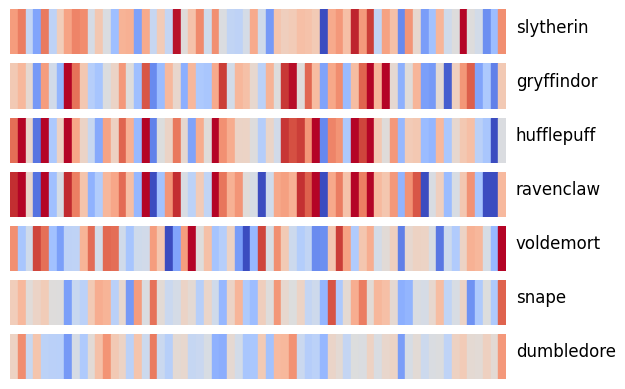

In [14]:
def embed(word):
  return model(torch.tensor(WORD_TO_ID[word]).to(DEVICE)).detach().cpu().numpy()

words = ['slytherin', 'gryffindor', 'hufflepuff', 'ravenclaw',
         'voldemort', 'snape', 'dumbledore']
embeddings = [embed(word) for word in words]
num_embed = len(embeddings)
cmap = matplotlib.cm.coolwarm
fig, axes = plt.subplots(num_embed, 1)
norm = matplotlib.colors.Normalize(vmin=embeddings[0].min(), vmax=embeddings[0].max())
for idx in range(num_embed):
  ax = axes[idx]
  embedding = embeddings[idx]
  for i in range(embed_dim):
    ax.add_patch(Rectangle((i/embed_dim, 0),.05,1, color=cmap(norm(embedding[i]))))
  ax.text(1.02, .5, words[idx], fontsize=12)
  ax.axis('off')
plt.show()